In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
import scipy.stats as st
from scipy.optimize import brentq

In [23]:
def av_p_recr(D0, L, gamma):
    """ 
    Average probability that a clonotype is recruited 
    """
    s = np.sum([binom(L,H) * np.exp(-(H/D0)**gamma) for H in range(L+1)])
    return s*2**(-L)

def w_pass(H, D0, L, gamma):
    """
    Probability weights (to be normalized) that a clonotype having hamming distance
    H is present among the recruted ones
    """
    return binom(L,H) * np.exp(-(H/D0)**gamma)

def mean_std_h_pass(D0, L, gamma):
    """
    Get the average and standard deviation of the recruited hamming distances
    """
    Hs = np.arange(L+1)
    wh = w_pass(Hs, D0, L, gamma)
    mean = np.sum(wh * Hs) / np.sum(wh)
    m2 = np.sum(wh * Hs**2) / np.sum(wh)
    return mean, np.sqrt(m2 - mean**2)
    
def get_logtau(hs, D0, L, gamma, av_logtau=-4.0, std_logtau=2.5):
    """
    It transforms the hamming distnces in log-affinities by shifting their
    average and standard deviation to match the empirical ones
    """
    mean, std = mean_std_h_pass(D0, L, gamma)
    b = std_logtau / std
    a = av_logtau + b*mean
    return a - b*np.array(hs, dtype=float)

In [33]:
N_tot = 10**6
L = 30
N_recruit = 100
gamma_recr = 1
new_ag_mutations = [0,1] # string positions at which a new antigen mutates

D0 = brentq(lambda x : av_p_recr(x, L, gamma_recr) - N_recruit/N_tot, 0.01, 5) 

# Generating the strings and computing the hamming distance against the original antigen
strings = np.random.randint(0,2,size=(N_tot, L))
h_dists = np.sum(strings, axis=1)

# Selecting the clonotypes according to their recruitment prob
recruit_probs = np.exp(-(h_dists/D0)**gamma_recr)
unifs = np.random.rand(N_tot)
recruit_strings = strings[unifs < recruit_probs,:]
h_recruit = np.sum(recruit_strings, axis=1)

# How the hamming distances change against a mutated antigen
h_new_ag = np.copy(h_recruit)
for mi in new_ag_mutations:
    h_new_ag[recruit_strings[:,0] == 1] -= 1
    h_new_ag[recruit_strings[:,0] == 0] += 1

logtaus = get_logtau(h_recruit, D0, L, gamma_recr)
logtaus_new_ag = get_logtau(h_new_ag, D0, L, gamma_recr)

-3.9303583094275587 -4.720455300762828
2.380421742123632 2.7958206897002253
9.538461538461538 10.346153846153847


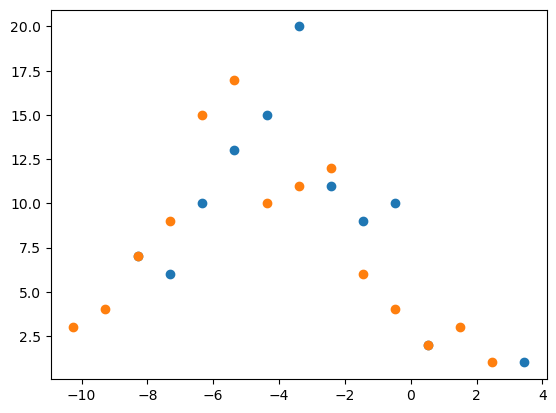

In [34]:
uni_tau, count_tau = np.unique(logtaus, return_counts=True)
plt.scatter(uni_tau, count_tau)

uni_tau_new, count_tau_new = np.unique(logtaus_new_ag, return_counts=True)
plt.scatter(uni_tau_new, count_tau_new)

print(np.mean(logtaus), np.mean(logtaus_new_ag))
print(np.std(logtaus), np.std(logtaus_new_ag))
print(np.mean(h_recruit), np.mean(h_new_ag))